In [1]:
# Standard library imports
import glob
import os
import shutil
import time

# Third party imports
from matplotlib import colors
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.ndimage import generic_filter
from scipy.spatial import distance
import shapefile as shp
from shapely.geometry import Point
import vtk
import pyvista as pv


# Flopy imports
import flopy
import flopy.utils
from flopy.discretization import StructuredGrid
from flopy.export import vtk as vtk_export
from flopy.export.shapefile_utils import *
from flopy.mf6.utils.reference import SpatialReference
from flopy.modflow import ModflowNwt, ModflowRch, ModflowStr
from flopy.utils import CellBudgetFile, Raster, ZoneBudget, binaryfile as bf
from flopy.utils.gridgen import StructuredGrid as StructuredGridGen
from flopy.utils.util_array import Util2d
from flopy.mf6.modflow.mfgwfrcha import ModflowGwfrcha
from flopy.mf6.modflow.mfgwfsfr import ModflowGwfsfr
from flopy.mf6.modflow.mfgwfriv import ModflowGwfriv
from flopy.utils import ZoneBudget6, CellBudgetFile


print("Modules imported successfully.")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Modules imported successfully.


In [2]:
# Specify the directory you want to clean up
directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS'

# Get a list of all files in the directory
all_files = glob.glob(os.path.join(directory, '*'))

# Specify the file types you want to keep
keep_patterns = ['*.py', '*.ipynb', '*.exe']

# Get a list of files to keep
keep_files = []
for pattern in keep_patterns:
    keep_files.extend(glob.glob(os.path.join(directory, pattern)))

# Specify the directories to skip
skip_directories = ['__pycache__']

# Get a list of files to delete
delete_files = set(all_files) - set(keep_files)

# Delete the files
for file in delete_files:
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue

    if os.path.isfile(file):
        os.remove(file)
    elif os.path.isdir(file):
        shutil.rmtree(file)

In [3]:

os.chdir('C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS')

In [4]:
import mod_utils_SS
import importlib
importlib.reload(mod_utils_SS)

<module 'mod_utils_SS' from 'c:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow_SS\\mod_utils_SS.py'>

In [5]:
# Geometry
geometry_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Marylidia_data\\DEM\\DEM"
shp_Gondebeek_path = os.path.join(geometry_path,"Catchment_Gondebeek_v2.shp")
raster_DEM_path= os.path.join(geometry_path,'DEM_Gondebeek.asc')
raster_A100t_path = os.path.join(geometry_path,'A0100_t.asc')
raster_Paniseliaan_Brusseliaan_Aquifer_path=os.path.join(geometry_path,'A0600_Ledo_Paniseliaan_Brusseliaan_Aquifer.asc')
raster_Paniseliaan_Aquitard_path= os.path.join(geometry_path,'A0700_Paniseliaan_Aquitard.asc')    
raster_eperiaan_Aquifer_path= os.path.join(geometry_path,'A0800_Leperiaan_Aquifer.asc')    

In [6]:
modelname = 'Gondebeek_SS'
model_dir = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow_SS"

In [7]:
# Load shape
shp_obj = shp.Reader(shp_Gondebeek_path)

# Read shape
feature = shp_obj.shapeRecords()[0]

# Domain extension
bbox = feature.shape.bbox
Lx = -(bbox[0]-bbox[2]) #m
Ly = -(bbox[1]-bbox[3]) #m

# Horizontal discretization
delr = 100
delc = 100

# Number of model rows, and cols
nrow = Ly / delr
ncol = Lx / delc

# Actualizar nrow y ncol
nrow = int(np.round(nrow+.5))
ncol = int(np.round(ncol+.5))

# Actualizar Lx y Ly
Ly = nrow*delr
Lx = ncol*delc

# Origins round to left and up
xul = int(bbox[0]//100*100)
yul = int((bbox[3])//100*100+100)

# Number of layers between guide layers
gls_lays = np.array([1,1,1,1])

# Total N of layers are calculated
nlay = gls_lays.sum()

In [8]:
file_list = [raster_DEM_path,raster_A100t_path,raster_Paniseliaan_Brusseliaan_Aquifer_path,raster_Paniseliaan_Aquitard_path,raster_eperiaan_Aquifer_path]

interp_elevs = mod_utils_SS.interpolate_to_grid(file_list, xul, yul, nrow, ncol, delr, delc)


In [9]:
interp_elevs = mod_utils_SS.check_layer_elevs(interp_elevs,1.01)
len(gls_lays)
len(interp_elevs)

5

In [10]:
botm = np.zeros((nlay,nrow,ncol),dtype=float)
botm = mod_utils_SS.fill_botm_array(botm,interp_elevs,gls_lays)
topm = mod_utils_SS.fill_topm_array(botm,interp_elevs,gls_lays)

In [11]:
# Fecha inicial y final
year_0 = 2015; month_0 = 1; day_0 = 1 
year_F = 2015; month_F = 1; day_F = 2 

SP = mod_utils_SS.Constru_SP(year_0, month_0, day_0, year_F, month_F, day_F,steady_0=True, steady=True, timestep=1, scale='d', n_scale=1)
perlen, fecha_inicialSP, fecha_finalSP, nstp, tsmult, steady = SP
nper = len(perlen)


In [12]:
SP

([1.0], ['2015-01-01'], ['2015-01-02'], [1], [2.0], [True])

In [13]:
mf6_exe = os.path.join('mf6')  # Path to MODFLOW 6 executable

sim = flopy.mf6.MFSimulation(sim_name=modelname, version='mf6', exe_name=mf6_exe, sim_ws=model_dir)

tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS', nper=nper, perioddata=[(1, 1, 2)])

gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True)

ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='SIMPLE')

# Get the initial botm and top arrays
botm_array = botm.copy()
top_array = interp_elevs[0].copy()

# Create a mask where botm and top are not -1.000000E+09
mask = np.logical_and(botm_array != -1.000000E+09, top_array != -1.000000E+09)

# Create an IBOUND array based on the mask
ibound = np.where(mask, 1, 0)

# Change -1e9 to zero
botm_array[botm_array == -1.000000E+09] = 0
top_array[top_array == -1.000000E+09] = 0

# Define the lower-left y-coordinate
yll = 177000.0

# Calculate the total height of the model grid
total_height = nrow * delc

# Adjust the y-origin
yul = yll + total_height

# Create the ModflowGwfdis object with the updated y-origin
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top_array, botm=botm_array, xorigin=xul, yorigin=177000.0, idomain=ibound)
# Create the ModflowGwfnpf object with the ibound array
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=1, k=500)

strt = np.repeat(top_array[np.newaxis, :, :], nlay, axis=0)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)

# Create the OC package
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='Gondebeek_SS.cbc',
                             head_filerecord='Gondebeek_SS.hds',
                             saverecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')])

# Write the simulation
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model Gondebeek_SS...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...


In [14]:
# Load the shapefile for K and s:
k_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Marylidia_data\DEM\DEM\provincie_k_clipped.shp"
s_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Marylidia_data\DEM\DEM\provincie_s_clipped.shp"
k = gpd.read_file(k_path)
s = gpd.read_file(s_path)
# Print the attributes of the shapefile
print(k.columns)
print(s.columns)

Index(['node', 'row', 'column', 'icellpe_1_', 'icellpe_2_', 'icellpe_3_',
       'icellpe_4_', 'icellpe_5_', 'k_1', 'k_2', 'k_3', 'k_4', 'k_5', 'k33_1',
       'k33_2', 'k33_3', 'k33_4', 'k33_5', 'geometry'],
      dtype='object')
Index(['node', 'row', 'column', 'iconvert_1', 'iconvert_2', 'iconvert_3',
       'iconvert_4', 'iconvert_5', 'ss_1', 'ss_2', 'ss_3', 'ss_4', 'ss_5',
       'sy_1', 'sy_2', 'sy_3', 'sy_4', 'sy_5', 'geometry'],
      dtype='object')


In [15]:
gwf = sim.get_model("Gondebeek_SS")  # Replace "model_name" with the name of your model

mod_utils_SS.set_hydraulic_properties_mf6(sim, gwf, k, s, bbox, delr, delc, ['k_1', 'k_2', 'k_3', 'k_3'], 
                                   ['k33_1', 'k33_2', 'k33_3', 'k33_3'],['sy_1', 'sy_2', 'sy_3', 'sy_3'], ['ss_1', 'ss_2', 'ss_3', 'ss_3'])
#write lpf package 

sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model Gondebeek_SS...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...


In [16]:
gwf.npf.check()


npf PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0



Get the initial heads from pseudo_SS

In [17]:
# import flopy.utils.binaryfile as bf
# import flopy.modflow as mf

# # Load the head data from the first model
# headobj = bf.HeadFile('C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow\\Gondebeek.hds')
# head = headobj.get_data()

# # Extract the head data from the last stress period
# last_sp_heads = head[-1]

# # Load the second model
# model = mf.Modflow.load('Gondebeek_SS.nam')  # Replace 'Gondebeek_SS.nam' with the path to your name file

# # Remove the existing BAS package
# model.remove_package('BAS6')

# # Create a new BAS package with the updated initial heads
# bas = mf.ModflowBas(model, strt=last_sp_heads)

# # Write the updated model to a new set of files
# model.write_input()

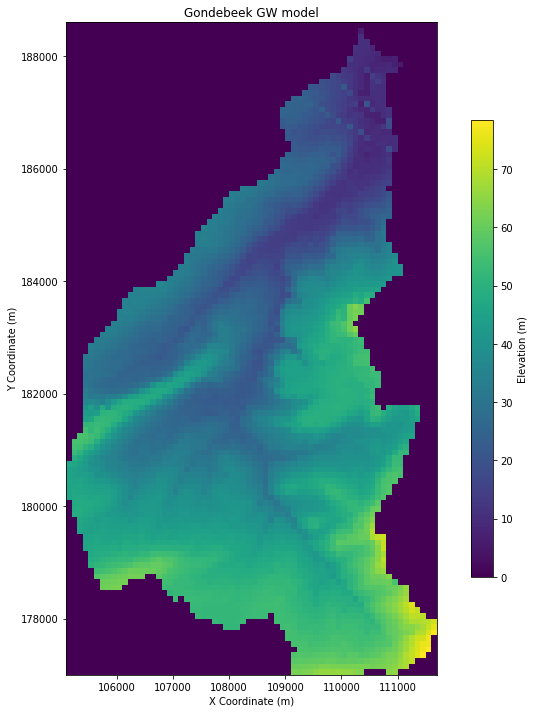

In [18]:

# Get the top layer of the model
top_layer = gwf.dis.top.array

# Define the minimum and maximum values for the colorbar
vmin, vmax = 0, top_layer.max()

# Create a figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a map of the model
modelmap = flopy.plot.PlotMapView(model=gwf)

# Plot the top layer of the model
quadmesh = modelmap.plot_array(top_layer, vmin=vmin, vmax=vmax)

# Plot the grid and inactive cells
#linecollection = modelmap.plot_grid()
#quadmesh = modelmap.plot_ibound(ibound=noflow, color_noflow='cyan')

# Add a colorbar with a label
cbar = plt.colorbar(quadmesh, shrink=0.7)
cbar.set_label('Elevation (m)')

# Add labels to the x and y axes
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')

# Add a title
plt.title("Gondebeek GW model")

# Save the plot as a PNG file
plt.savefig('Gondebeek_GW_model.png')

# Show the plot
plt.show()


Recharge

In [19]:
# Calculate the daily recharge rate in meters per day
recharge_rate = 0.0019902180502591182 / 3   # Convert from mm/day to m/day (and the third part only is infiltrated)

# Create a 2D array with the recharge rate
recharge_array = [[recharge_rate for _ in range(ncol)] for _ in range(nrow)]

# Get the groundwater flow model
gwf = sim.get_model("Gondebeek_SS")  # Replace "Gondebeek_SS" with the name of your model

# Get the number of stress periods
nper = sim.tdis.nper.data

# Create a dictionary with the recharge rate for each stress period
recharge = {kper: recharge_array for kper in range(nper)}

# Get the groundwater flow model
gwf = sim.get_model("Gondebeek_SS")  # Replace "Gondebeek_SS" with the name of your model

# Create the recharge package
rch = ModflowGwfrcha(gwf, recharge=recharge)

# Write the package
rch.write()


In [20]:
#First: Clip river shapefile (WLas):

river_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Streams\\Shapefile"
shp_river = os.path.join(river_path,"Wlas.shp")


# Load your polygon and line shapefiles
polygon = gpd.read_file(shp_Gondebeek_path)
line = gpd.read_file(shp_river)

# Reproject the line GeoDataFrame to match the CRS of the polygon GeoDataFrame
line = line.to_crs(polygon.crs)

# Perform the clip operation
clipped = gpd.clip(line, polygon)

shp_river_clipped = os.path.join(river_path,"Wlas_clipped.shp")
# Save the clipped part to a new shapefile
clipped.to_file(shp_river_clipped)

In [21]:
from rtree import index
import geopandas as gpd
from shapely.geometry import Polygon

# Get the groundwater flow model
gwf = sim.get_model("Gondebeek_SS")  # Replace "Gondebeek_SS" with the name of your model

# Get the top elevation array and active cell data from your model
top_elev = gwf.dis.top.array
ibound = gwf.dis.idomain.array  # get the array of active cells

clipped = gpd.read_file(shp_river_clipped)
layer = 0  # layer number (only layer 1)
# Create a spatial index
idx = index.Index()

# Populate spatial index with bounding boxes of active cells
for row in range(gwf.modelgrid.nrow):
    for col in range(gwf.modelgrid.ncol):
        if ibound[layer, row, col] > 0:
            x_center = gwf.modelgrid.xcellcenters[row, col]
            y_center = gwf.modelgrid.ycellcenters[row, col]
            dx = gwf.modelgrid.delc[row] / 2
            dy = gwf.modelgrid.delr[col] / 2
            bounds = (x_center - dx, y_center - dy, x_center + dx, y_center + dy)
            idx.insert((row * gwf.modelgrid.ncol) + col, bounds)
            

# Initialize the segment and reach numbers
segment = 1
reach = 1
flow = 1

# Convert the shapefile to a list of [layer, row, column, segment, reach, flow, strhc1, strtop, slope, strthick, width, rough] for each reach
stream_data = []
processed_cells = set()  # Set to keep track of processed cells

for index, data in clipped.iterrows():
    # Get the vertices of the LineString
    vertices = list(data['geometry'].coords)
    
    for i in range(len(vertices) - 1):
        # Calculate the minimum and maximum x and y coordinates
        minx = min(vertices[i][0], vertices[i+1][0])
        miny = min(vertices[i][1], vertices[i+1][1])
        maxx = max(vertices[i][0], vertices[i+1][0])
        maxy = max(vertices[i][1], vertices[i+1][1])
        
        # Get intersecting cells using spatial index
        coordinates = (minx, miny, maxx, maxy)
        intersecting_cells = list(idx.intersection(coordinates))
       
        if not intersecting_cells:
            continue
        
        # Process only the intersecting active cells
        for cell_index in intersecting_cells:
            row = cell_index // gwf.modelgrid.ncol
            col = cell_index % gwf.modelgrid.ncol
            
            # Skip the specific cells
            if (row, col) in [(1, 52), (6, 58)]:
                continue
            
            # Skip if the cell has already been processed
            if (row, col) in processed_cells:
                continue
            
            layer = 0  # layer number (only layer 1)
            # Check if the cell is within the active domain
            if ibound[layer, row, col] > 0:
                
                # Calculate the reach length as the distance between the centers of the cells
                next_row, next_col = gwf.modelgrid.intersect(vertices[i+1][0], vertices[i+1][1])
                # Check if the next cell is within the active domain
                if ibound[layer, next_row, next_col] > 0:
                    rchlen = ((gwf.modelgrid.xcellcenters[row, col] - gwf.modelgrid.xcellcenters[next_row, next_col])**2 + 
                              (gwf.modelgrid.ycellcenters[row, col] - gwf.modelgrid.ycellcenters[next_row, next_col])**2)**0.5
                    strtop = top_elev[row, col]  # streambed top (top elevation of the cell)
                    # Calculate the change in elevation
                    delta_elev = top_elev[row, col] - top_elev[next_row, next_col]
                    # Calculate the slope
                    slope = abs(delta_elev / rchlen)
                    if np.isnan(slope):
                        slope=0.018
                    strthick = 1.0  # streambed thickness
                    strhc1 = 43.0  # streambed conductance
                    stage = 1.0  # initial stream stage
                    width = 1.0  # stream width
                    rough = 1.0  # roughness coefficient
                    cell_id = (layer, row, col)
                    stream_data.append([cell_id, stage+strtop,strhc1,strtop])
                    reach += 1  # increment the reach number
                    processed_cells.add((row, col))  # Add the cell to the set of processed cells
                    
    segment += 1  # increment the segment number
    reach = 1  # reset the reach number for the next segment

# Get the number of stress periods
nstress = sim.tdis.nper.data

# Initialize the stress period data
stress_period_data = []

# Iterate over the stream data
for i in range(len(stream_data)):
    # Get the reach number
    reach = stream_data[i][0]
    
    # Add the reach to the stress period data with status and 'active' keyword
    stress_period_data.append((reach, 'status', 'active'))

# Convert the list to a dictionary
stress_period_data = {0: stress_period_data}
# Initialize the connection data
# Initialize the connection data
# Initialize the connection data
connection_data = []

# Iterate over the stream data
for i in range(len(stream_data) - 1):
    # Get the reach number and the number of the next reach
    reach = stream_data[i][0]
    next_reach = stream_data[i+1][0] if i+1 < len(stream_data) else None

    # Add the connection to the connection data
    if next_reach is not None:
        connection_data.append({"ifno": [reach], "ic": [next_reach]})
    else:
        connection_data.append({"ifno": [reach], "ic": [0]})



# Add the connection data to the SFR package
riv = ModflowGwfriv(gwf, pname='riv', save_flows=True, stress_period_data=stream_data)
riv.write()




INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 762 based on size of stress_period_data


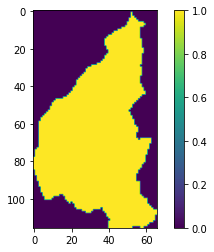

In [22]:
# Choose the layer you want to plot
layer = 0

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the ibound array for the chosen layer
cax = ax.imshow(ibound[layer], cmap='viridis')

# Add a colorbar
cbar = fig.colorbar(cax)

# Show the plot
plt.show()

In [23]:
# # Load the daily evaporation data
# et_dir = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\ET"
# csv_et_daily = os.path.join(et_dir, 'et_daily.csv')
# df_et_daily = pd.read_csv(csv_et_daily, delimiter=',')

# # Get the ET , and only 20% s real ET
# evtr = 0.00163906717512467 * 0.2

# # Create the EVT package
# evt = flopy.modflow.ModflowEvt(sim, nevtop=1, evtr=evtr, ipakcb=50)
# # Add the EVT package to the MODFLOW model
# sim.add_package(evt)

# evt.write_file()
# sim.write_input()

In [24]:
# # Load the model
# model = mf.Modflow.load('Gondebeek_SS.nam')  # Replace 'Gondebeek_SS.nam' with the path to your name file

# # Get the UPW package
# upw = model.get_package('UPW')

# # Multiply the hydraulic conductivity arrays by 10
# hk = upw.hk.array * 100
# vka = upw.vka.array * 10

# # Remove the existing UPW package
# model.remove_package('UPW')

# # Create a new UPW package with the updated hydraulic conductivity values
# upw = mf.ModflowUpw(model, hk=hk, vka=vka)

# # Write the updated model to a new set of files
# model.write_input()

sim.write_simulation()
sim.check()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model Gondebeek_SS...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package riv...
Checking model "Gondebeek_SS"...

Gondebeek_SS MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    npf package: zero or negative horizontal hydraulic conductivity values
    npf package: vertical hydraulic conductivity values below checker threshold of 1e-11
    npf package: vertical hydraulic conductivity values above checker threshold of 100000.0
    npf package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    npf package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    riv package: BC indices valid
    

In [25]:
# Run the model
sim.run_simulation()

FloPy is using the following executable to run the model: mf6.exe


                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

(True, [])

Check heads before running

Check heads after running

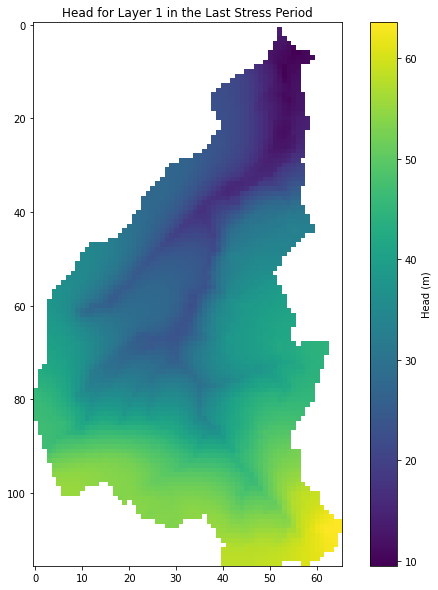

In [26]:

# Load the head data
hds = flopy.utils.HeadFile('Gondebeek_SS.hds')

# Get all times and stress periods/time steps
times = hds.get_times()
kstpkper = hds.get_kstpkper()

# Get the last time and stress period/time step
last_time = times[-1]
last_kstpkper = kstpkper[-1]

# Get the head for the last stress period and time step
head = hds.get_data(totim=last_time)

# Mask values lower than -900
head = np.ma.masked_where(head > 50000, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
  loading solution package gondebeek_ss...


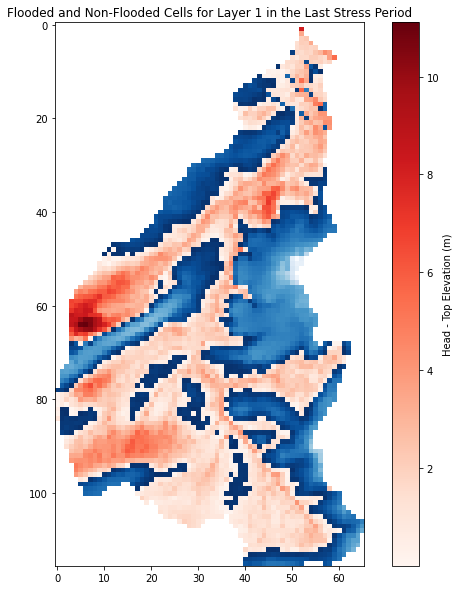

In [27]:
# Load the model
sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS')  # replace 'Gondebeek_SS.nam' with your model name
gwf = sim.get_model('Gondebeek_SS')
# Get the top elevation of the cells
top = gwf.dis.top.array

# Calculate the difference between the head and the top elevation
diff = head[1, :, :] - top

# Create a mask for the flooded cells (where the difference is positive)
flooded = np.ma.masked_where(diff <= 0, diff)

# Create a mask for the non-flooded cells (where the difference is zero or negative)
non_flooded = np.ma.masked_where(diff > 0, diff)

# Plot the non-flooded cells in blue and the flooded cells in red
plt.figure(figsize=(10, 10))
plt.imshow(non_flooded, cmap='Blues', interpolation='none')
plt.imshow(flooded, cmap='Reds', interpolation='none')
plt.colorbar(label='Head - Top Elevation (m)')
plt.title('Flooded and Non-Flooded Cells for Layer 1 in the Last Stress Period')
plt.show()

In [28]:
# Load the model
sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS')
gwf = sim.get_model('Gondebeek_SS')

# Get the idomain array from the dis package of the model
idomain = gwf.dis.idomain.array

# Create the zone array from the idomain array
zon = np.where(idomain == 0, 1, idomain)

zonbud = gwf.output.zonebudget(zon)
zonbud.change_model_ws(directory)
zonbud.write_input()
zonbud.run_model()

df = zonbud.get_dataframes(net=True)
df = df.reset_index()

# Delete the zonbud object
del zonbud

# Print the contents of the CSV file for the last time step and stress period
print(df)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
  loading solution package gondebeek_ss...
FloPy is using the following executable to run the model: zbud6.exe
                              ZONEBUDGET Version 6
                             U.S. GEOLOGICAL SURVEY
                            VERSION 6.4.4 02/13/2024
.....
 
Normal Termination
   totim    name        ZONE_1
0    1.0  STO_SS      0.000000
1    1.0     RIV -28846.011225
2    1.0    RCHA  28844.893619
3    1.0  ZONE_0      0.000000
4    1.0  ZONE_1      0.000000


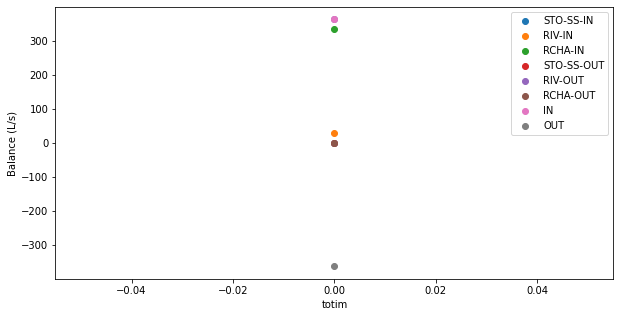

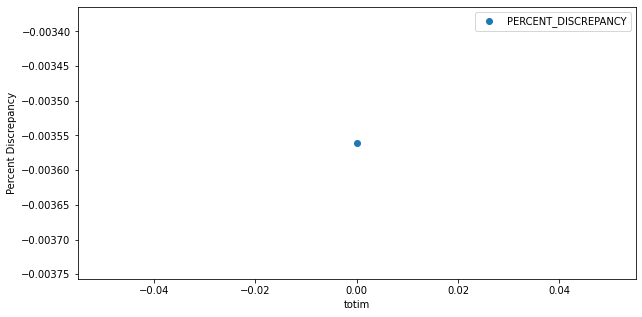

In [29]:


# Load the budget data from the CSV file
budget_df = pd.read_csv('zonebud.csv')

# Compute the total inflow and outflow for each time step
budget_df['IN'] = budget_df.filter(regex='-IN$').sum(axis=1)
budget_df['OUT'] = -budget_df.filter(regex='-OUT$').sum(axis=1)  # Make the OUT terms negative

# Compute the percent discrepancy
budget_df['PERCENT_DISCREPANCY'] = (budget_df['OUT'] + budget_df['IN']) / budget_df['IN'] * 100

# Select only the "-IN" and "-OUT" terms
budget_df = budget_df.filter(regex='IN$|OUT$|PERCENT_DISCREPANCY')

# Convert the flow values from cubic meters per day to liters per second, excluding the percent discrepancy
for component in budget_df.columns:
    if component != 'PERCENT_DISCREPANCY':
        budget_df[component] = pd.to_numeric(budget_df[component], errors='coerce') / 86.4

# Plot each component of the balances, excluding the "percent discrepancy"
plt.figure(figsize=(10, 5))
for component in budget_df.columns:
    if component != 'PERCENT_DISCREPANCY':
        if len(budget_df.index) == 1:
            plt.scatter(budget_df.index, budget_df[component], label=component)
        else:
            plt.plot(budget_df.index, budget_df[component], label=component)

# Add a legend
plt.legend()

# Add labels
plt.xlabel('totim')
plt.ylabel('Balance (L/s)')  # Update the y-axis label

# Show the plot
plt.show()

# Plot the "percent discrepancy" separately
plt.figure(figsize=(10, 5))
if len(budget_df.index) == 1:
    plt.scatter(budget_df.index, budget_df['PERCENT_DISCREPANCY'], label='PERCENT_DISCREPANCY')
else:
    plt.plot(budget_df.index, budget_df['PERCENT_DISCREPANCY'], label='PERCENT_DISCREPANCY')

# Add a legend
plt.legend()

# Add labels
plt.xlabel('totim')
plt.ylabel('Percent Discrepancy')

# Show the plot
plt.show()

In [30]:
# Load the model
sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS')
gwf = sim.get_model('Gondebeek_SS')

# Get the modelgrid from the model
modelgrid = gwf.modelgrid

# Create a vtk object
vtkobj = flopy.export.vtk.Vtk(gwf, modelgrid=modelgrid, vertical_exageration=10,binary=False)

# Flatten the entire 3D array of bottom elevations
botm_flattened = gwf.dis.botm.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(botm_flattened, "botm")

# Calculate the top elevations
botm = gwf.dis.botm.array
top = np.empty_like(botm)
top[0] = gwf.dis.top.array
top[1:] = botm[:-1]

# Flatten the entire 3D array of top elevations
top_flattened = top.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(top_flattened, "top")

# Flatten the entire 3D array of hydraulic conductivity
hk_flattened = gwf.npf.k.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(hk_flattened, "k")

# Flatten the entire 3D array of specific storage
ss_flattened = gwf.sto.ss.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ss_flattened, "ss")

# Flatten the entire 3D array of specific yield
sy_flattened = gwf.sto.sy.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(sy_flattened, "sy")

# Flatten the entire 3D array of ibound
ibound_flattened = gwf.dis.idomain.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ibound_flattened, "ibound")

# Write the VTK object to a file
vtkobj.write("model_SS.vtk")



loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
  loading solution package gondebeek_ss...


In [31]:
# Set the backend for PyVista
pv.set_jupyter_backend('trame')

# Convert the VTK object to a PyVista mesh
mesh = vtkobj.to_pyvista()

# Apply a threshold filter to keep only cells where ibound equals 1
thresholded_mesh = mesh.threshold(0.5, scalars="ibound")

# List all available point data
print(thresholded_mesh)

# Plot the thresholded mesh with a specific property
# Replace 'property_name' with the name of the property you want to visualize
thresholded_mesh.plot(scalars='k', cpos=[mesh.points[0], mesh.points[1], (0, 0, 0)], show_edges=False)

# Save the thresholded mesh to a VTK file
thresholded_mesh.save("Gondebeek_SS_act.vtk")

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\trame\ui\__init__.py:1: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame.ui')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\pkg_resources\__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


UnstructuredGrid (0x18b0a125a00)
  N Cells:    17392
  N Points:   139136
  X Bounds:   1.051e+05, 1.117e+05
  Y Bounds:   1.770e+05, 1.885e+05
  Z Bounds:   -2.823e+02, 7.836e+02
  N Arrays:   6


Widget(value='<iframe src="http://localhost:56756/index.html?ui=P_0x18b02c59970_0&reconnect=auto" class="pyvis…

In [32]:
botm=gwf.dis.botm.array
mesh["botm"] = np.ravel(botm)
# Apply a threshold filter to keep only cells where ibound equals 1
thresholded_mesh = mesh.threshold(0.5, scalars="ibound")

thresholded_mesh.plot(cpos=[mesh.points[0], mesh.points[1], (0, 0, 0)], scalars="botm", show_edges=False)

Widget(value='<iframe src="http://localhost:56756/index.html?ui=P_0x18b086b6f70_1&reconnect=auto" class="pyvis…